In [6]:
import pickle
A_FILE_NAME = "A_testing_num_epochs_data.pkl"
TEXTWIDTH = 5.78853# inches

def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

## Retrieve data

In [14]:
import wandb
import pandas as pd
import pickle

run_ids = []
with open('A_testing_num_epochs_ids.txt', 'r') as file:
    for line in file:
        run_ids.append(line.strip())


api = wandb.Api()
history_dict = {}
metrics = ["accuracy","eval_loss","train_st2_loss"]
for run_id in run_ids:
    run = api.run(f"ricu/fantastic-umbrella/{run_id}")
    
    # Fetch the 'num_train_epochs' value
    num_train_epochs = run.config['num_train_epochs']
    train_size = run.config["training_size"]
    seed = run.config["seed"]
    
    # Fetch the history and extract the 'accuracy' column
    history = run.scan_history(keys=["accuracy","eval_loss","train_st2_loss"])
    metrics = pd.DataFrame([row for row in history]).add_suffix(f'_{seed}')
    
    if train_size not in history_dict:
        history_dict[train_size] = {}
    # If 'num_train_epochs' is not in the dictionary, add it
    if num_train_epochs not in history_dict[train_size]:
        history_dict[train_size][num_train_epochs] = pd.DataFrame()

    history_dict[train_size][num_train_epochs] = pd.concat([history_dict[train_size][num_train_epochs],metrics],axis=1)
    
for num_train_epochs, accuracy in history_dict.items():
    print(f'num_train_epochs: {num_train_epochs}')
    print(accuracy)
history_dict = {k1: {k2: history_dict[k1][k2] for k2 in sorted(history_dict[k1])} for k1 in sorted(history_dict)}

# history_dict = {k: history_dict[k] for k in sorted(history_dict)}
with open(A_FILE_NAME,'wb') as f:
    pickle.dump(history_dict,f)

KeyboardInterrupt: 

## Plot data

In [15]:
import pickle
with open(A_FILE_NAME,'rb') as f:
    history_dict = pickle.load(f)

#### Plot median metric at each timestep

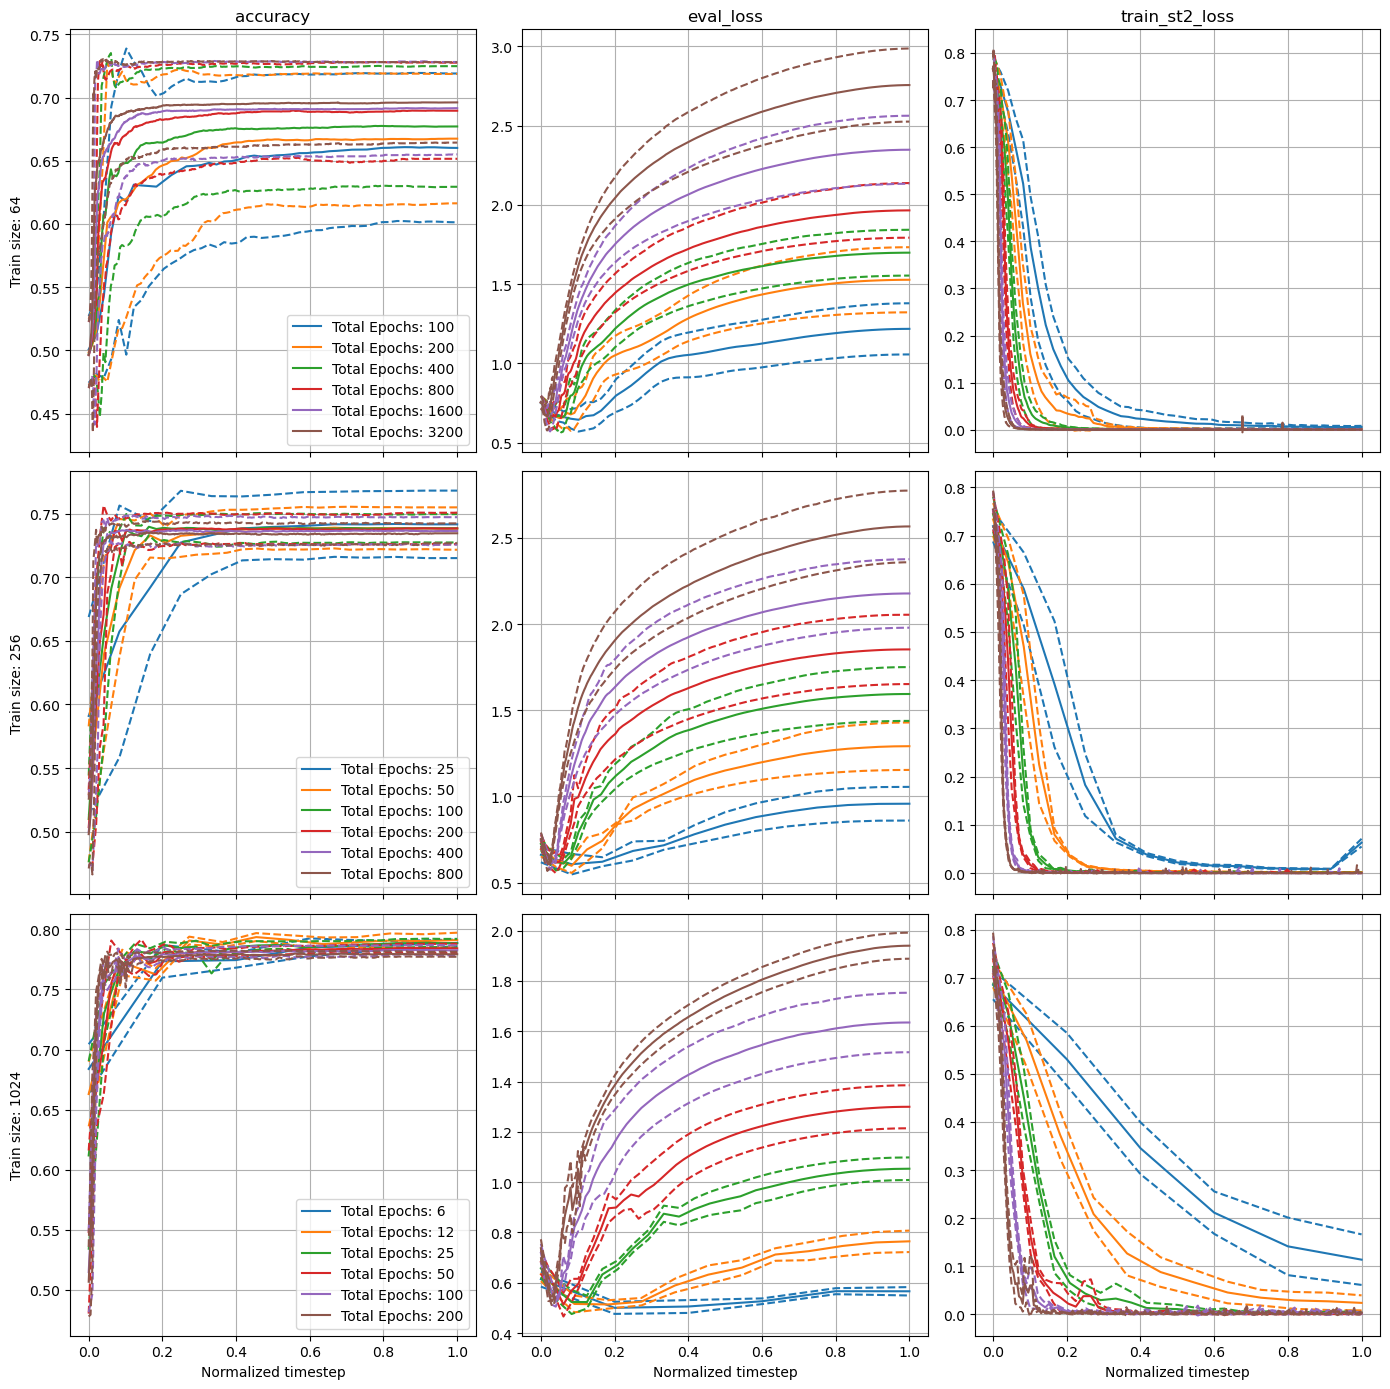

In [23]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(metrics),
    sharex=True,
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )

for idx, (train_size, sub_dict) in enumerate(history_dict.items()):
    for idy, metric in enumerate(metrics):
        for num_train_epochs, history_df in sub_dict.items():
            metric_columns = history_df.filter(regex=f'{metric}_').copy()
            # Compute the mean, standard deviation, and median
            metric_columns['mean'] = metric_columns.mean(axis=1)
            metric_columns['std'] = metric_columns.std(axis=1)
            metric_columns['median'] = metric_columns.median(axis=1)
        
            # Normalize the index (timesteps) to a range from 0 to 1
            normalized_index = metric_columns.index / metric_columns.index.max()
            # Plot the median on the respective subplot
            line, = axs[idx,idy].plot(normalized_index, metric_columns['mean'], label=f'Total Epochs: {num_train_epochs}')
            # color = line.get_color()
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] - metric_columns['std'], color=color, linestyle='--')
            # axs[idx,idy].plot(normalized_index, metric_columns['mean'] + metric_columns['std'], color=color, linestyle='--')
            # Add a shaded region for the standard deviation
            # axs[idx,idy].fill_between(normalized_index, (metric_columns['median'] - metric_columns['std']), (metric_columns['median'] + metric_columns['std']), alpha=1)
        if idx == 0:
            axs[idx,idy].set_title(metric)
        if idy == 0:
            axs[idx,idy].set_ylabel(f'Train size: {train_size}')
        if idx == len(history_dict) - 1:
            axs[idx,idy].set_xlabel('Normalized timestep')
            # axs[idx,idy].set_xlabel('Epoch')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idy == 0:
            axs[idx,idy].legend()

# Show the plot
plt.tight_layout()
# plt.savefig('A_testing_num_epochs_plot_normalized.pdf', format='pdf')
plt.show()

#### Plot curve of median of best accuracy

KeyError: 'accuracy_2'

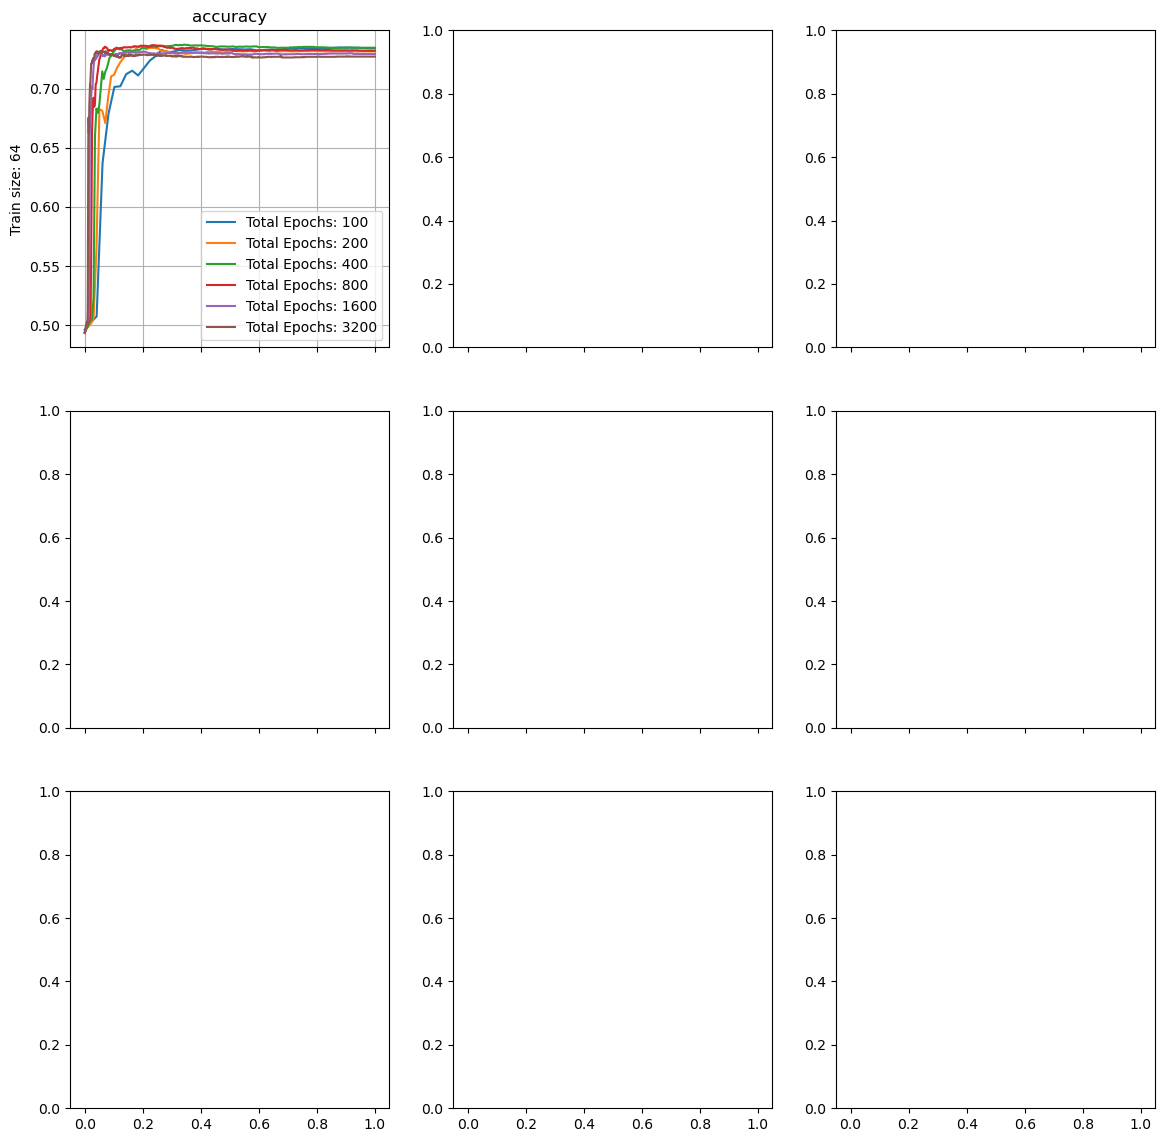

In [13]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'eval_loss', 'train_st2_loss']

# Create a new figure
fig, axs = plt.subplots(
    3,
    len(metrics),
    sharex=True,
    figsize = (14,14)
    # figsize = (TEXTWIDTH,TEXTWIDTH)
    )


for idx, (train_size, sub_dict) in enumerate(history_dict.items()):
    best_acc_index = {}
    for idy, metric in enumerate(metrics):
        
        for num_train_epochs, history_df in sub_dict.items():
            metric_columns = history_df.filter(regex=f'{metric}_').copy()
            if metric == 'accuracy':
                best_acc_index[num_train_epochs] = metric_columns.max(axis=0).idxmax()



            metric_columns = metric_columns[best_acc_index[num_train_epochs]]
            # Compute the mean, standard deviation, and median
            # metric_columns['mean'] = metric_columns.mean(axis=1)
            # metric_columns['std'] = metric_columns.std(axis=1)
            # metric_columns['median'] = metric_columns.median(axis=1)
        
            # Normalize the index (timesteps) to a range from 0 to 1
            normalized_index = metric_columns.index / metric_columns.index.max()
            # Plot the median on the respective subplot
            axs[idx,idy].plot(normalized_index, metric_columns, label=f'Total Epochs: {num_train_epochs}')
            
            # Add a shaded region for the standard deviation
            # axs[idx,idy].fill_between(normalized_index, (metric_columns['median'] - metric_columns['std']), (metric_columns['median'] + metric_columns['std']), alpha=0.2)
        if idx == 0:
            axs[idx,idy].set_title(metric)
        if idy == 0:
            axs[idx,idy].set_ylabel(f'Train size: {train_size}')
        if idx == len(history_dict) - 1:
            axs[idx,idy].set_xlabel('Normalized timestep')
            # axs[idx,idy].set_xlabel('Epoch')

        axs[idx,idy].grid(True,which='major')
        axs[idx,idy].grid(True,which='minor')

        if idy == 0:
            axs[idx,idy].legend()

# Show the plot
plt.tight_layout()
# plt.savefig('A_testing_num_epochs_plot_normalized.pdf', format='pdf')
plt.show()